## Prototypical Networks For Few-Shot Learning
Install easyfsl

In [ ]:
!pip install easyfsl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.2/65.2 kB 4.9 MB/s eta 0:00:00


In [ ]:
import torch
from torch.utils.data import DataLoader
from torchvision.models import resnet18
from torch import nn, optim
from torchvision.datasets import Omniglot
from tqdm import tqdm
from torchvision import transforms
import json
from easyfsl.utils import plot_images, sliding_average
from easyfsl.samplers import TaskSampler
import matplotlib.pyplot as plt

In [ ]:
image_size = 28
train_set = Omniglot(
    root="./data",
    background=True,
    transform=transforms.Compose(
        [
            transforms.Grayscale(num_output_channels=3),
            transforms.RandomResizedCrop(image_size),
            #transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
        ]
    ),
    download=True,
)
test_set = Omniglot(
    root="./data",
    background=False,
    transform=transforms.Compose(
        [
            # Omniglot images have 1 channel, but our model will expect 3-channel images
            transforms.Grayscale(num_output_channels=3),
            transforms.Resize([int(image_size * 1.15), int(image_size * 1.15)]),
            transforms.CenterCrop(image_size),
            transforms.ToTensor(),
        ]
    ),
    download=True,
)

100%|██████████| 9464212/9464212 [00:00<00:00, 217090040.41it/s]

Extracting ./data/omniglot-py/images_background.zip to ./data/omniglot-py


100%|██████████| 6462886/6462886 [00:00<00:00, 164909376.62it/s]

Extracting ./data/omniglot-py/images_evaluation.zip to ./data/omniglot-py


In [ ]:
class PrototypicalNetworks(nn.Module):
    def __init__(self, backbone: nn.Module):
        super(PrototypicalNetworks, self).__init__()
        self.backbone = backbone

    def forward(
        self,
        support_images: torch.Tensor,
        support_labels: torch.Tensor,
        query_images: torch.Tensor,
    ) -> torch.Tensor:
        # Trích xuât thuộc tính của các hình ảnh
        z_support = self.backbone.forward(support_images)
        z_query = self.backbone.forward(query_images)

        # Số lớp cần phân loại
        n_way = len(torch.unique(support_labels))
        # tính toán vector đặc trưng trung bình cho mỗi nhãn dựa trên các vector hỗ trợ trong tập support
        z_proto = torch.cat(
            [
                z_support[torch.nonzero(support_labels == label)].mean(0)
                for label in range(n_way)
            ]
        )
        # tính khoảng cách euclidean từ tập query tới các lớp có trong tập support
        dists = torch.cdist(z_query, z_proto)

        # tính toán điểm cho từng lớp và trả về, lớp được dự đoán sẽ có score cao nhất
        scores = -dists
        return scores

convolutional_network = resnet18(pretrained=True)
convolutional_network.fc = nn.Flatten()
model = PrototypicalNetworks(convolutional_network).cuda()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 54.1MB/s]


**Select Parameter**

In [ ]:
N_WAY = 25  # Số lớp trong 1 task
N_SHOT = 5  # Số ảnh của mỗi lớp trong tập support
N_QUERY = 5  # Số ảnh của mỗi lớp trong tập query
N_EVALUATION_TASKS = 100

# chuyển đổi data phù hợp với đầu vào cùa mô hình
test_set.get_labels = lambda: [
    instance[1] for instance in test_set._flat_character_images
]
test_sampler = TaskSampler(
    test_set, n_way=5, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_EVALUATION_TASKS
)

test_loader = DataLoader(
    test_set,
    batch_sampler=test_sampler,
    num_workers=12,
    pin_memory=True,
    collate_fn=test_sampler.episodic_collate_fn,
)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


**Show example of data test**

In [ ]:
(
    example_support_images,
    example_support_labels,
    example_query_images,
    example_query_labels,
    example_class_ids,
) = next(iter(test_loader))


**Test model before train**

In [ ]:
model.eval()
example_scores = model(
    example_support_images.cuda(),
    example_support_labels.cuda(),
    example_query_images.cuda(),
).detach()

_, example_predicted_labels = torch.max(example_scores.data, 1)

print("Label truth / lable predict")
for i in range(len(example_query_labels)):
    print(
        f"{test_set._characters[example_class_ids[example_query_labels[i]]]} / {test_set._characters[example_class_ids[example_predicted_labels[i]]]}"
    )

Label truth / lable predict
Angelic/character12 / Angelic/character12
Angelic/character12 / Angelic/character12
Angelic/character12 / Angelic/character12
Angelic/character12 / Angelic/character12
Angelic/character12 / Angelic/character12
Angelic/character09 / Angelic/character09
Angelic/character09 / Angelic/character09
Angelic/character09 / Angelic/character09
Angelic/character09 / Angelic/character09
Angelic/character09 / Angelic/character09
Malayalam/character27 / Malayalam/character27
Malayalam/character27 / Malayalam/character27
Malayalam/character27 / Malayalam/character27
Malayalam/character27 / Malayalam/character27
Malayalam/character27 / Malayalam/character27
Keble/character09 / Keble/character09
Keble/character09 / Keble/character09
Keble/character09 / Keble/character09
Keble/character09 / Keble/character09
Keble/character09 / Keble/character09
Tibetan/character04 / Tibetan/character04
Tibetan/character04 / Tibetan/character04
Tibetan/character04 / Tibetan/character04
Tibeta

**Evaluate Accurancy**

In [ ]:
def evaluate_on_one_task(
    support_images: torch.Tensor,
    support_labels: torch.Tensor,
    query_images: torch.Tensor,
    query_labels: torch.Tensor,
) -> [int, int]:
#trả về số lượng task dự đoán đúng và tổng số task
    return (
        torch.max(
            model(support_images.cuda(), support_labels.cuda(), query_images.cuda())
            .detach()
            .data,
            1,
        )[1]
        == query_labels.cuda()
    ).sum().item(), len(query_labels)


def evaluate(data_loader: DataLoader):
    total_predictions = 0
    correct_predictions = 0
    # no_grad() tells torch not to keep in memory the whole computational graph (it's more lightweight this way)
    model.eval()
    with torch.no_grad():
        for episode_index, (
            support_images,
            support_labels,
            query_images,
            query_labels,
            class_ids,
        ) in tqdm(enumerate(data_loader), total=len(data_loader)):

            correct, total = evaluate_on_one_task(
                support_images, support_labels, query_images, query_labels
            )

            total_predictions += total
            correct_predictions += correct
    return 100 * float(correct_predictions)/total_predictions

acc=evaluate(test_loader)

print(        f"\nAccuracy of my model: {(acc):.2f}%"    )


100%|██████████| 100/100 [00:06<00:00, 16.60it/s]


Accuracy of my model: 85.64%


Currently, the accuracy of the model is quite good. However, we will train it further on the Omniglot dataset to further improve its accuracy.

## Training Model

In [ ]:
N_TRAINING_EPISODES = 5000
N_VALIDATION_TASKS = 100

# convert data for training
train_set.get_labels = lambda: [instance[1] for instance in train_set._flat_character_images]
train_sampler = TaskSampler(
    train_set, n_way=N_WAY, n_shot=N_SHOT, n_query=N_QUERY, n_tasks=N_TRAINING_EPISODES
)
train_loader = DataLoader(
    train_set,
    batch_sampler=train_sampler,
    num_workers=12,
    pin_memory=True,
    collate_fn=train_sampler.episodic_collate_fn,
)

**Training**

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.75)

def fit(
    support_images: torch.Tensor,
    support_labels: torch.Tensor,
    query_images: torch.Tensor,
    query_labels: torch.Tensor,
) -> float:
    optimizer.zero_grad()
    classification_scores = model(
        support_images.cuda(), support_labels.cuda(), query_images.cuda()
    )

    loss = criterion(classification_scores, query_labels.cuda())
    loss.backward()
    optimizer.step()

    return loss.item()

In [ ]:
# Train the model
log_update_frequency = 100

accuracy={}
all_loss = []
model.train()
with tqdm(enumerate(train_loader), total=len(train_loader)) as tqdm_train:
    for episode_index, (
        support_images,
        support_labels,
        query_images,
        query_labels,
        _,
    ) in tqdm_train:
        loss_value = fit(support_images, support_labels, query_images, query_labels)
        all_loss.append(loss_value)
        if episode_index %100==0:
          accuracy[episode_index]=evaluate(test_loader)
        if episode_index % log_update_frequency == 0:
            tqdm_train.set_postfix(loss=sliding_average(all_loss, log_update_frequency))

100%|██████████| 5000/5000 [19:46<00:00,  4.21it/s, loss=0.652]


Evaluate accurancy of model after train on omniglot

In [ ]:
accurancy=evaluate(test_loader)
print(f"\nAccuracy of my model: {accurancy}%")

100%|██████████| 100/100 [00:03<00:00, 29.64it/s]


Accuracy of my model: 99.04%


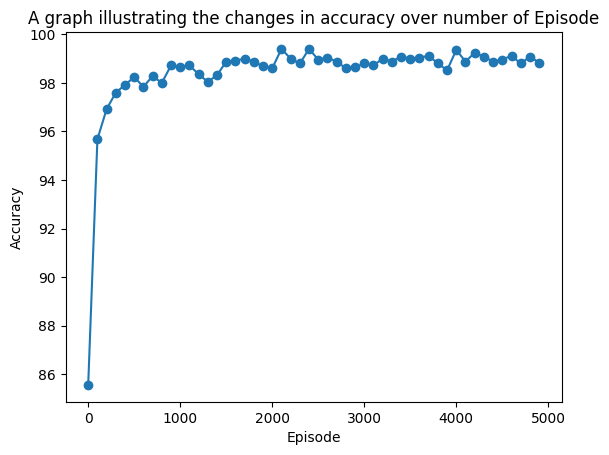

In [ ]:
def plot_accuracy(training_results):
    # Lấy danh sách số lần training và độ chính xác tương ứng
    training_iterations = list(training_results.keys())
    accuracies = list(training_results.values())

    # Vẽ biểu đồ
    plt.plot(training_iterations, accuracies, marker='o')
    plt.xlabel('Episode')
    plt.ylabel('Accuracy')
    plt.title('A graph illustrating the changes in accuracy over number of Episode')
    plt.show()
plot_accuracy(accuracy)

**Save your model**

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# torch.save(model, "/content/drive/MyDrive/model_fsl.pth")